## COVID X-ray Image Classification with EfficientNet

### Importing Required Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras import layers
from tensorflow.keras import Model
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

In [2]:
!pip install -U efficientnet
import efficientnet.keras as efn

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.7/dist-packages (1.1.1)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_txt = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Covid Xray/train.txt', sep=" ", header=None)
train_txt.columns= ["Sl.no","File_Name","Status","Source"]
train_txt.head()

,Sl.no,File_Name,Status,Source
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [5]:
train_txt.drop(["Sl.no","Source"], axis=1, inplace=True)

In [6]:
test_txt= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Covid Xray/test.txt', sep=" ", header=None)
test_txt.columns= ["Sl.no","File_Name","Status","Source"]
test_txt.head()

,Sl.no,File_Name,Status,Source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [7]:
test_txt.drop(["Sl.no","Source"], axis=1, inplace=True)

In [9]:
test_dest_pth= './drive/My Drive/Colab Notebooks/Covid Xray/test/'
test_txt['File_Name'] = test_dest_pth + test_txt['File_Name']

In [10]:
test_txt

,File_Name,Status
0,./drive/My Drive/Colab Notebooks/Covid Xray/te...,positive
1,./drive/My Drive/Colab Notebooks/Covid Xray/te...,positive
2,./drive/My Drive/Colab Notebooks/Covid Xray/te...,positive
3,./drive/My Drive/Colab Notebooks/Covid Xray/te...,positive
4,./drive/My Drive/Colab Notebooks/Covid Xray/te...,positive
...,...,...
395,./drive/My Drive/Colab Notebooks/Covid Xray/te...,negative
396,./drive/My Drive/Colab Notebooks/Covid Xray/te...,negative
397,./drive/My Drive/Colab Notebooks/Covid Xray/te...,negative
398,./drive/My Drive/Colab Notebooks/Covid Xray/te...,negative


In [11]:
dest_pth= './drive/My Drive/Colab Notebooks/Covid Xray/train/'
train_txt['File_Name'] = dest_pth+train_txt['File_Name']

In [12]:
train_txt['Status'].value_counts()

negative    13793
positive     2158
Name: Status, dtype: int64

In [13]:
neg = train_txt.Status[train_txt.Status.eq("negative")].sample(2158).index
pos = train_txt.Status[train_txt.Status.eq("positive")].sample(2158).index 

train_txt = train_txt.loc[neg.union(pos)]

In [14]:
train_txt.shape

(4316, 2)

### Model Training

In [15]:
train_df, valid_df=train_test_split(train_txt, test_size=0.2, stratify=train_txt["Status"], random_state=123)

In [16]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [26]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory=None,
x_col="File_Name",
y_col="Status",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=valid_df,
directory=None,
x_col="File_Name",
y_col="Status",
subset="validation",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_txt,
directory=None,
x_col="File_Name",
y_col="Status",
batch_size=32,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(256,256))

Found 2589 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [18]:
base_model = efn.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(base_model.input,predictions)

In [21]:
model_final.compile('rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
eff_history = model_final.fit_generator(train_generator, validation_data = valid_generator, steps_per_epoch = 50, epochs = 5)

Epoch 1/5
50/50 [==============================] - 1247s 25s/step - loss: 32.2141 - accuracy: 0.7090 - val_loss: 1.5879 - val_accuracy: 0.9167
Epoch 2/5
50/50 [==============================] - 452s 9s/step - loss: 2.8045 - accuracy: 0.8716 - val_loss: 1.1698 - val_accuracy: 0.8750
Epoch 3/5
50/50 [==============================] - 252s 5s/step - loss: 2.2072 - accuracy: 0.8606 - val_loss: 0.4900 - val_accuracy: 0.9398
Epoch 4/5
50/50 [==============================] - 199s 4s/step - loss: 1.0791 - accuracy: 0.8992 - val_loss: 0.2003 - val_accuracy: 0.9444
Epoch 5/5
50/50 [==============================] - 194s 4s/step - loss: 0.5865 - accuracy: 0.9146 - val_loss: 0.2763 - val_accuracy: 0.9630


### Model Validation & Prediction

In [27]:
model_final.evaluate_generator(generator=valid_generator,steps=10)

[0.17142486572265625, 0.9900000095367432]

In [28]:
model_final.evaluate_generator(generator=test_generator,steps=10)

[0.37293338775634766, 0.9593750238418579]

In [29]:
pred=model_final.predict_generator(test_generator)

In [30]:
len(pred)

400

In [31]:
# Prediction for Test Data
preds=pred.round(decimals=0)
for p in preds:
    print (p)

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]


In [32]:
test_txt['Status'].value_counts()

negative    200
positive    200
Name: Status, dtype: int64

### Plotting Model Loss & Accuracy

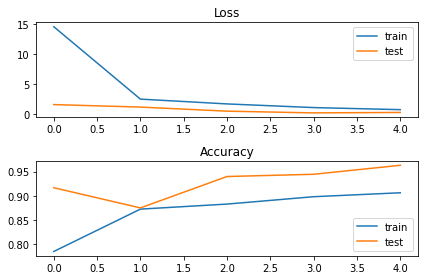

In [33]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(eff_history.history['loss'], label='train')
pyplot.plot(eff_history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(eff_history.history['accuracy'], label='train')
pyplot.plot(eff_history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

### Model Performance Analysis

In [37]:
test_generator.class_indices

{'negative': 0, 'positive': 1}

In [35]:
test_txt['Status'][test_txt['Status']=='positive']=1.0
test_txt['Status'][test_txt['Status']=='negative']=0.0

In [36]:
test_txt['Status'].astype('float')

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
395    0.0
396    0.0
397    0.0
398    0.0
399    0.0
Name: Status, Length: 400, dtype: float64

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, preds))
mat = confusion_matrix(test_generator.classes, preds)
print('Classification Report')
target_names = ['Negative', 'Positive']
print(classification_report(test_generator.classes, preds, target_names=target_names))

Confusion Matrix
[[187  13]
 [  7 193]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.96      0.94      0.95       200
    Positive       0.94      0.96      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



#### Model has a Recall of 0.95 

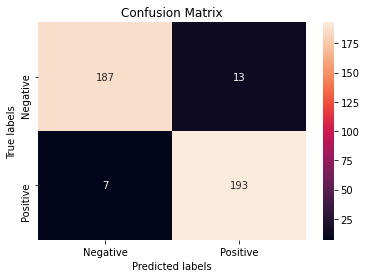

In [39]:
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

### Checking Model Predictions

In [45]:
# Picking out a Positive Test Sample
test_txt['File_Name'][1]

'./drive/My Drive/Colab Notebooks/Covid Xray/test/MIDRC-RICORD-1C-419639-001464-39871-0.png'

In [79]:
import numpy as np
from keras.preprocessing import image
test_image= image.load_img('./drive/My Drive/Colab Notebooks/Covid Xray/test/MIDRC-RICORD-1C-419639-001464-39871-0.png'
                           ,target_size =(256,256))

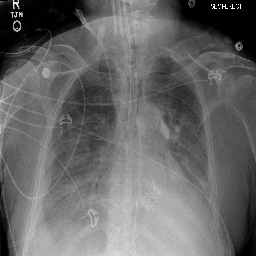

In [80]:
test_image

In [81]:
test_image = image.img_to_array(test_image)
test_image=test_image.reshape(1,256,256,3)

In [101]:
result = np.where(model_final.predict(test_image) > 0.5, 1, 0)
result

array([[1]])

#### The Test Image is a Positive Sample & Model Result also indicates that the sample is Positive

### Validation of Predictions

In [98]:
# We are taking a sample of 4 Positive & Negative Images
# We will look at the predictions generated for the above images

pos_imgs=[]
neg_imgs=[]
pos_imgs.append(test_txt['File_Name'][60])
pos_imgs.append(test_txt['File_Name'][79])
pos_imgs.append(test_txt['File_Name'][138])
pos_imgs.append(test_txt['File_Name'][141])
neg_imgs.append(test_txt['File_Name'][287])
neg_imgs.append(test_txt['File_Name'][252])
neg_imgs.append(test_txt['File_Name'][253])
neg_imgs.append(test_txt['File_Name'][243])
imgs =[]
for i in pos_imgs:
    imgs.append(i)
for i in neg_imgs:
    imgs.append(i)

In [97]:
# Model generated predictions for above Images
preds[[60,79,138,141,287,252,253,243]]

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

#### It is found that for randomly picked 4 Positive & 4 Negative Images. Model Prediction Output has classified the samples correctly

<Figure size 432x288 with 0 Axes>

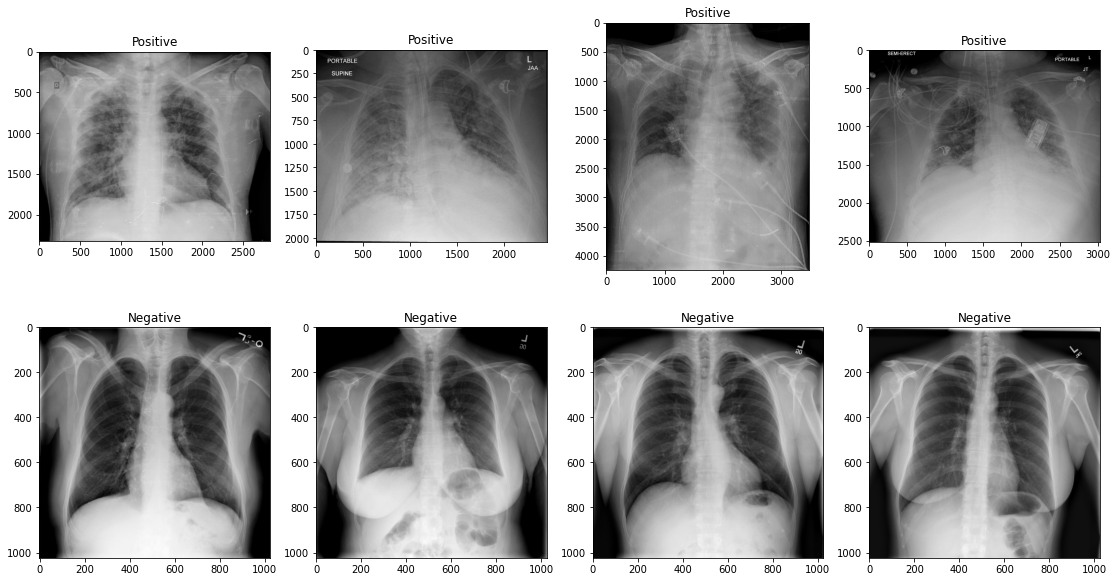

In [99]:
# Visualization of the above selected Images
plt.figure()
images=[]

#subplot(r,c) provide the no. of rows and columns

for i in range(len(imgs)):
    it_image = plt.imread(imgs[i]) 
    images.append(it_image)
f, axarr = plt.subplots(2,4,figsize=(19,10)) 
axarr[0,0].imshow(images[0],cmap='gray')
axarr[0,1].imshow(images[1],cmap='gray')
axarr[0,2].imshow(images[2],cmap='gray')
axarr[0,3].imshow(images[3],cmap='gray')
axarr[1,0].imshow(images[4],cmap='gray')
axarr[1,1].imshow(images[5],cmap='gray')
axarr[1,2].imshow(images[6],cmap='gray')
axarr[1,3].imshow(images[7],cmap='gray')
axarr[0,0].title.set_text('Positive')
axarr[0,1].title.set_text('Positive')
axarr[0,2].title.set_text('Positive')
axarr[0,3].title.set_text('Positive')
axarr[1,0].title.set_text('Negative')
axarr[1,1].title.set_text('Negative')
axarr[1,2].title.set_text('Negative')
axarr[1,3].title.set_text('Negative')
plt.show()